# Koalas - ML

**Context**


Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

**Data**

- *id*: Unique ID for the customer
- *Gender*: Gender of the customer
- *Age*:	Age of the customer
- *Driving_License*:	0 - Customer does not have DL, 1- Customer already has DL
- *Region_Code*:	Unique code for the region of the customer
- *Previously_Insured*:	0- Customer doesn't have Vehicle Insurance, 1- Customer already has Vehicle Insurance
- *Vehicle_Age*:	Age of the Vehicle
- *Vehicle_Damage*:	0- Customer didn't get vehicle damaged in the past, 1- Customer got vehicle damaged in the past. 
- *Annual_Premium*:	The amount customer needs to pay as premium in the year
- *PolicySalesChannel*: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- *Vintage*:	Number of Days, Customer has been associated with the company
- *Response*:	0-Customer is not interested, 1- Customer is interested, 

**Fonte**
link: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction



## Summary

Nessa etapara do trabalho foi realizado o balanceamento dos dados, seleção de feature e a modelagem. 
- Para o balanceamento foi utilizado o under sampling. 
- Para a seleção de features foram testados 5 métodos, dentre eles de filtro e wrappen. Foram selecionados dois conjuntos de features com base nos resultados, sendo um com 7 e outro com 10 features.
- Para a modelagem foram testados diveros algoritmos, sendo todos ele realizados para os dois conjuntos de features selecionadas. Dentre eles os melhores foram SVM para a classe 1 e o LightGMB para a classe 0

# Importanto bibliotecas e dados

In [2]:
!pip install xgboost
!pip install lightgbm
!pip install imblearn

     |████████████████████████████████| 173.6 MB 4.1 kB/s             
     |████████████████████████████████| 2.0 MB 24.1 MB/s            
     |████████████████████████████████| 199 kB 21.5 MB/s            
     |████████████████████████████████| 189 kB 56.9 MB/s            


In [18]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report, plot_confusion_matrix,ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split,  StratifiedKFold, KFold, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb


from sklearn.feature_selection import SelectKBest, f_classif, chi2, SequentialFeatureSelector, RFECV


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [19]:
# importanto os dados de treino
bucket = 'insurance-prediction'
folder = 'landing'
data_key = 'train.csv'
data_location = 's3://{}/{}/{}'. format(bucket,folder, data_key)

df = pd.read_csv(data_location)

In [20]:
df.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


# Balanceamento dos dados

Pela análise de EDA, notou-se que as classes da váriável resposta não está balanceada, sendo assim, é necessáro fazer um balanceamento dos dados para um melhor predição.

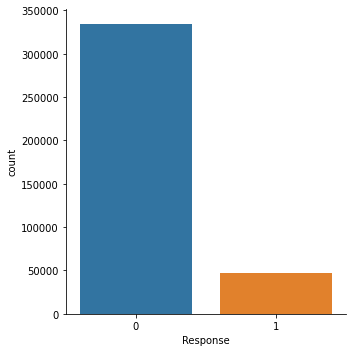

In [8]:
sns.catplot(data = df, x = 'Response', kind = 'count');

In [19]:
target_count = df.Response.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 334399
Class 1: 46710
Proportion: 7.16 : 1


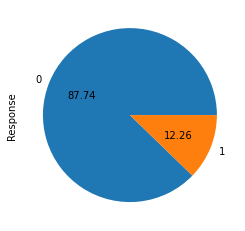

In [7]:
df.Response.value_counts().plot.pie(autopct='%.2f');

Existem diversas tecnicas de balanceamento dos dados, mas neste projeto foi utilizado o under-sampling


In [3]:
# Aplicando enconder nas variáveis categóricas
data_cat = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
df= pd.get_dummies(df, columns = data_cat, drop_first=True)

In [4]:
X = df.drop(columns = ['Response']) # features
y = df['Response'] 

## Under-Sampling

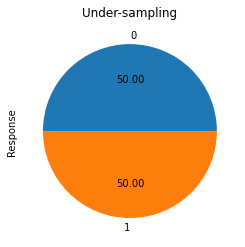

In [5]:
### Random Undersampling
#not majority -> resample all classes but the majority class

rus = RandomUnderSampler(sampling_strategy=1, random_state=42) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_under, y_under = rus.fit_resample(X, y)

ax = y_under.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [33]:
X_under.shape

(93420, 12)

In [34]:
y_under.shape

(93420,)

In [17]:
y_under.value_counts()

0    46710
1    46710
Name: Response, dtype: int64

# Seleção de Feature

**Separando os dados**

In [6]:
# escolhendo a semente para garantir a reproducibilidade dos resultados
# Quando  random.state = None, como default é utilizado o numpy.random. 
SEED = 42
np.random.seed(SEED)

# Na primeira etapa vamos dividir os dados em teste e um conjunto de dados restante, que chamarei de treino.
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, shuffle=True, stratify=y_under)

print ("treino")
print(X_train.shape)
print(y_train.shape)

print ("teste")
print(X_test.shape)
print(y_test.shape)

treino
(74736, 12)
(74736,)
teste
(18684, 12)
(18684,)


**Seleção de feauture**

Existem diversas formas e métodos de se realizar a seleção de features, sendo uma delas a adição no pipeline  do modelo. Porém, como o intuito desse projeto é aprender como realizar as diversas etapas de um projeto de ML, irei fazer a seleção em separado para compreender como alguns métodos funcionam .
Para tal, testarei 4  métodos de seleção de features e comprar elas, para então fazer a retiradas das features.Para isso serão utilzados os métodos:

- Filter: SelectKBest(f_classif e chi²), Feature Importance(random forest)
- Wrappen: SequentialFeatureSelector (random forest) e RFE (random forest)


In [7]:
X_train =X_train.drop(columns= ['id'])

In [38]:
len(X_train.columns)

11

**SelectKBest - f_classif**


In [39]:
FC = SelectKBest(score_func=f_classif, k=6) 
FC.fit(X_train,y_train)
features = FC.transform(X_train)
print(" Colunas Selecionadas: ", FC.get_feature_names_out(input_features=None))

 Colunas Selecionadas:  ['Age' 'Policy_Sales_Channel' 'Previously_Insured_1'
 'Vehicle_Age_< 1 Year' 'Vehicle_Age_> 2 Years' 'Vehicle_Damage_Yes']


**SelectKBest - Chi²**

In [40]:
CHI2 = SelectKBest(score_func=chi2, k=6) 
CHI2.fit(X_train,y_train)
features = CHI2.transform(X_train)
print(" Colunas Selecionadas: ", CHI2.get_feature_names_out(input_features=None))

 Colunas Selecionadas:  ['Age' 'Annual_Premium' 'Policy_Sales_Channel' 'Previously_Insured_1'
 'Vehicle_Age_< 1 Year' 'Vehicle_Damage_Yes']


**Feature Importance**

In [41]:
FI = RandomForestClassifier(n_estimators=10, random_state=SEED)
FI.fit(X_train, y_train)
print(FI.feature_importances_)

[0.11537862 0.08570352 0.15843682 0.0502542  0.17978921 0.01089955
 0.00072221 0.19987578 0.02400814 0.00459193 0.17034001]


In [42]:
feature_importances = pd.DataFrame(FI.feature_importances_, index= X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(6)

,importance
Previously_Insured_1,0.199876
Vintage,0.179789
Vehicle_Damage_Yes,0.170340
Annual_Premium,0.158437
Age,0.115379
Region_Code,0.085704


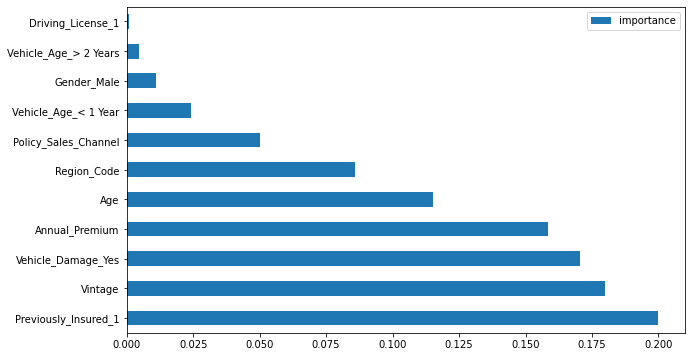

In [43]:
feature_importances.plot(kind='barh', figsize=(10,6));

**SequentialFeatureSelector**

In [44]:
SFS = RandomForestClassifier(n_estimators= 10, random_state= SEED)
cv = KFold(n_splits=10, shuffle=True)

feature_selector = SequentialFeatureSelector(SFS, 
                                             n_features_to_select = 6,
                                             direction = 'backward',
                                             scoring = 'f1',
                                             cv = cv)

feature_selector.fit(X_train, y_train)

print("nome das colunas", feature_selector.get_feature_names_out(input_features=None))                                            

nome das colunas ['Age' 'Annual_Premium' 'Policy_Sales_Channel' 'Vintage'
 'Previously_Insured_1' 'Vehicle_Damage_Yes']


**RFE**

In [49]:
rfe = RandomForestClassifier(n_estimators= 10, random_state= SEED)
cv = KFold(n_splits=10, shuffle=True)


rfe_selector = RFECV(rfe, 
                     min_features_to_select = 4,
                     step = 1,
                     scoring = 'f1',
                     cv = cv)

rfe_selector.fit(X_train, y_train)

print("nome das colunas", rfe_selector.get_feature_names_out(input_features=None))

nome das colunas ['Age' 'Region_Code' 'Annual_Premium' 'Policy_Sales_Channel' 'Vintage'
 'Gender_Male' 'Previously_Insured_1' 'Vehicle_Age_< 1 Year'
 'Vehicle_Age_> 2 Years' 'Vehicle_Damage_Yes']


**Comparando os resultados**


In [50]:
print("**F_Classify\n", FC.get_feature_names_out(input_features=None))
print("**Chi²\n", CHI2.get_feature_names_out(input_features=None))
print("**SequentialFeatureSelector\n", feature_selector.get_feature_names_out(input_features=None))
print("**RFECV\n", rfe_selector.get_feature_names_out(input_features=None))
print("**Feature importances\n", feature_importances.index[0:6])

**F_Classify
 ['Age' 'Policy_Sales_Channel' 'Previously_Insured_1'
 'Vehicle_Age_< 1 Year' 'Vehicle_Age_> 2 Years' 'Vehicle_Damage_Yes']
**Chi²
 ['Age' 'Annual_Premium' 'Policy_Sales_Channel' 'Previously_Insured_1'
 'Vehicle_Age_< 1 Year' 'Vehicle_Damage_Yes']
**SequentialFeatureSelector
 ['Age' 'Annual_Premium' 'Policy_Sales_Channel' 'Vintage'
 'Previously_Insured_1' 'Vehicle_Damage_Yes']
**RFECV
 ['Age' 'Region_Code' 'Annual_Premium' 'Policy_Sales_Channel' 'Vintage'
 'Gender_Male' 'Previously_Insured_1' 'Vehicle_Age_< 1 Year'
 'Vehicle_Age_> 2 Years' 'Vehicle_Damage_Yes']
**Feature importances
 Index(['Previously_Insured_1', 'Vintage', 'Vehicle_Damage_Yes',
       'Annual_Premium', 'Age', 'Region_Code'],
      dtype='object')


Em geral, as features escolhidas foram semelhantes. Comparando as features em cada métodos, nota-se que:

* Colunas em comum entre os 5 métodos são:
    - Age
    - Previously_Insured_1
    - Vehicle_Damage_Yes

<br>

* Colunas em comum entre 4 dos 5 métodos são:
    - Annual_Premium
    - Policy_Sales_Channel

<br>

* Colunas em comum entre 3 dos 5 métodos são:
    - Vintage
    - Vehicle_Age_< 1 Year


Verifica-se que o método SequentialFeatureSelector e o Chi² foram os que selecionaram as features mais escolhidas. Além disso, verifica-se que para o  método RFE, quase todas as features são importantes.

Para esse estudo será feito uma mescla entre os métodos SequentialFeatureSelector e o Chi² (mix) e utilizando quase todas as features (RFE).


In [8]:
X_train = X_train.rename (columns={'Vehicle_Age_< 1 Year': 'Vehicle_Age_maior_1Year',
                           'Vehicle_Age_> 2 Years':'Vehicle_Age_maior_2Year'})

X_train_mix= X_train[['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
                 'Previously_Insured_1', 'Vehicle_Damage_Yes', 'Vehicle_Age_maior_1Year']]

X_train_RFE = X_train[['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
                       'Gender_Male', 'Previously_Insured_1', 'Vehicle_Age_maior_1Year',
                       'Vehicle_Age_maior_2Year', 'Vehicle_Damage_Yes']]

## Métricas de avalição de modelo

In [9]:
# Criando um dicionário com as métricas a serem utilizadas 
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='macro'),
                 'recall': make_scorer(recall_score, average='macro'),
                 'f1': make_scorer(f1_score, average='macro'),
                 'rocAUC': make_scorer(roc_auc_score, average='macro')
                 }

# Criando uma função para calcular e imprimir as métricas escolhidas
def metricas(grid):
    
    idx = grid.best_index_
   
    acc_mean = grid.cv_results_['mean_test_accuracy'][idx]  
    acc_std= grid.cv_results_['std_test_accuracy'][idx]
     
    
    print ("Acurácia: ", acc_mean.round(4))
    print("Intervalo da acurácia: [%.2f, %.2f]" % ((acc_mean - 2 * acc_std)*100, (acc_mean + 2 * acc_std) * 100))

    print (" ")

    print ("Precision: ", grid.cv_results_['mean_test_precision'][idx].round(4))
    print ("Recall: ", grid.cv_results_['mean_test_recall'][idx].round(4))
    print ("F1 Score: ", grid.cv_results_['mean_test_f1'][idx].round(4))
    print ("AUROC: ", grid.cv_results_['mean_test_rocAUC'][idx].round(4))

## Regreção Logística

In [13]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_RL = LogisticRegression(random_state=SEED)


# grid parâmetros
param_gridRL = {'penalty': ['l1','l2', 'elasticnet'], 
              'C': [0.001,0.01,0.1,1,10,100,1000],
              'class_weight': ['dic', 'balanced', None],
              'max_iter': [100,1000,10000]}
                 
# instanciando o RandomizedSearch
gridRL = RandomizedSearchCV(model_RL,
                    param_gridRL,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [14]:
gridRL.fit(X_train_mix, y_train)

print("best:", gridRL.best_params_)
print("score:", gridRL.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRL)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'C': 0.1}
score: 0.7564194921699172
 
Acurácia:  0.764
Intervalo da acurácia: [64.11, 88.68]
 
Precision:  0.8079
Recall:  0.764
F1 Score:  0.7564
AUROC:  0.764


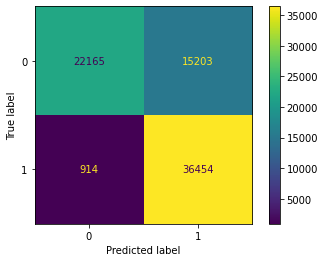

In [15]:
plot_confusion_matrix(gridRL,X_train_mix, y_train,values_format='d' );

In [56]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros ( quantos 0 a gente errou)
especificidade = 22165/ (22165 + 15203)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos ( quantos 1 a gente errou)
predito_negativo = 22165/ (22165 + 914)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.59
Predito Negativo: 0.96


In [14]:
FP = 15203
FN = 914
VP = 36454
VN = 22165
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 21.57%
Erro Falso Positivo: 40.68%
Erro Falso Negativo: 2.45%


**RFE**

In [16]:
gridRL.fit(X_train_RFE, y_train)

print("best:", gridRL.best_params_)
print("score:", gridRL.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRL)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'penalty': 'l2', 'max_iter': 10000, 'class_weight': 'balanced', 'C': 0.001}
score: 0.7561745452050753
 
Acurácia:  0.7638
Intervalo da acurácia: [63.42, 89.34]
 
Precision:  0.8082
Recall:  0.7638
F1 Score:  0.7562
AUROC:  0.7638


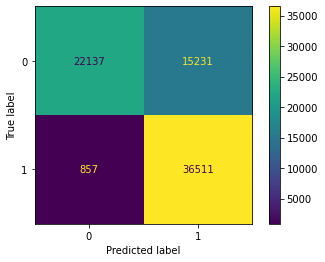

In [17]:
plot_confusion_matrix(gridRL,X_train_RFE, y_train,values_format='d' );

In [55]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 22137/ (22137 + 15231)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 22137/ (22137 + 857)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.59
Predito Negativo: 0.96


In [26]:
FP = 15231
FN = 857
VP = 36511
VN = 22137
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 21.53%
Erro Falso Positivo: 40.76%
Erro Falso Negativo: 2.29%


## SVM

In [18]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
pipe_SVC = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC(random_state=SEED))])


# grid parâmetros
param_gridSVM = {'model__C': [0.001,0.01,0.1,1,10,100,1000],
                 'model__kernel': ['rbf', 'poly', 'sigmoid', 'precomputed'],
                 'model__degree': [1,2,3,4,5,6,7,8,9,10, ],
                 'model__gamma': ['auto', 'scale'],
                 'model__class_weight': ['dict','balanced', None],
                 'model__max_iter': [100,1000,10000]}

                 
# instanciando o RandomizedSearch
gridSVM = RandomizedSearchCV(pipe_SVC,
                    param_gridSVM,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [19]:
gridSVM.fit(X_train_mix, y_train)

print("best:", gridSVM.best_params_)
print("score:", gridSVM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridSVM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__max_iter': 10000, 'model__kernel': 'poly', 'model__gamma': 'auto', 'model__degree': 1, 'model__class_weight': 'balanced', 'model__C': 0.1}
score: 0.5750610036327501
 
Acurácia:  0.6512
Intervalo da acurácia: [40.39, 89.85]
 
Precision:  0.5984
Recall:  0.6512
F1 Score:  0.5751
AUROC:  0.6512


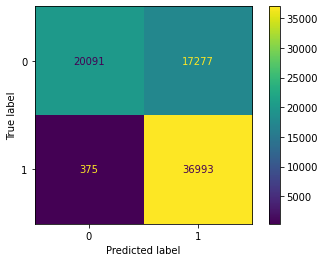

In [20]:
plot_confusion_matrix(gridSVM,X_train_mix, y_train,values_format='d' );

In [54]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 20091/ (20091 + 17277)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 20091/ (20091 + 375)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.54
Predito Negativo: 0.98


In [25]:
FP = 17277
FN = 375
VP = 36993
VN = 20091
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 23.62%
Erro Falso Positivo: 46.23%
Erro Falso Negativo: 1.00%


**RFE**

In [21]:
gridSVM.fit(X_train_RFE, y_train)

print("best:", gridSVM.best_params_)
print("score:", gridSVM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridSVM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'model__max_iter': 10000, 'model__kernel': 'poly', 'model__gamma': 'auto', 'model__degree': 1, 'model__class_weight': 'balanced', 'model__C': 0.1}
score: 0.5537499902094754
 
Acurácia:  0.6351
Intervalo da acurácia: [40.30, 86.72]
 
Precision:  0.5924
Recall:  0.6351
F1 Score:  0.5537
AUROC:  0.6351


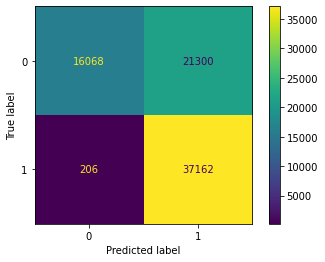

In [22]:
plot_confusion_matrix(gridSVM,X_train_RFE, y_train,values_format='d' );

In [53]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 16068/ (16068 + 21300)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 16068 / (16068 + 206)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.43
Predito Negativo: 0.99


In [24]:
FP = 21300
FN = 206
VP = 37162
VN = 16068
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 28.78%
Erro Falso Positivo: 57.00%
Erro Falso Negativo: 0.55%


## Random Forest

In [23]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_RF = RandomForestClassifier()


# grid parâmetros
param_gridRF = {'criterion': ['gini', 'entropy'],
                'max_depth': range(1,10),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'min_samples_split': range(1,10),
                'min_samples_leaf':range(1,10),
                'n_estimators': [10,100,1000,10000]} 

                 
# instanciando o RandomizedSearch
gridRF = RandomizedSearchCV(model_RF,
                    param_gridRF,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [24]:
gridRF.fit(X_train_mix, y_train)

print("best:", gridRF.best_params_)
print("score:", gridRF.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRF)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'entropy'}
score: 0.7906647127786156
 
Acurácia:  0.7941
Intervalo da acurácia: [78.50, 80.33]
 
Precision:  0.815
Recall:  0.7941
F1 Score:  0.7907
AUROC:  0.7941


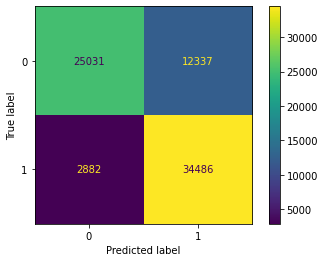

In [25]:
plot_confusion_matrix(gridRF,X_train_mix, y_train,values_format='d' );

In [52]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 25031/ (25031 + 12337)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 25031 / (25031 + 2882)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.67
Predito Negativo: 0.90


In [23]:
FP = 12337
FN = 2882
VP = 34486
VN = 25031
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))


Erro Global: 20.36%
Erro Falso Positivo: 33.01%
Erro Falso Negativo: 7.71%


**RFE**

In [26]:
gridRF.fit(X_train_RFE, y_train)

print("best:", gridRF.best_params_)
print("score:", gridRF.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridRF)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}
score: 0.7920032066386904
 
Acurácia:  0.7962
Intervalo da acurácia: [78.63, 80.61]
 
Precision:  0.822
Recall:  0.7962
F1 Score:  0.792
AUROC:  0.7962


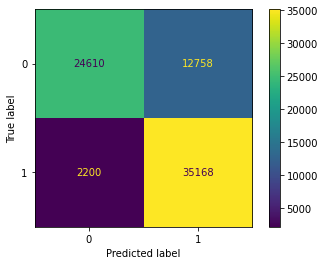

In [27]:
plot_confusion_matrix(gridRF,X_train_RFE, y_train,values_format='d' );

In [51]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24610/ (24610 + 12758)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24610 / (24610 + 2200)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.66
Predito Negativo: 0.92


In [22]:
FP = 12758
FN = 2200
VP = 35168
VN = 24610
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 20.01%
Erro Falso Positivo: 34.14%
Erro Falso Negativo: 5.89%


## AdaBoost

In [28]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_AB = AdaBoostClassifier()

# grid parâmetros
param_gridAB = {'learning_rate': [0.001,0.01,0.1,1,10,100,1000],
                'n_estimators': [1, 10, 20, 30,100,1000,10000],
                'algorithm': ['SAMME', 'SAMME.R']}

                
                 
# instanciando o RandomizedSearch
gridAB = RandomizedSearchCV(model_AB,
                    param_gridAB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [29]:
gridAB.fit(X_train_mix, y_train)

print("best:", gridAB.best_params_)
print("score:", gridAB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridAB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
score: 0.791522099574451
 
Acurácia:  0.7955
Intervalo da acurácia: [78.58, 80.52]
 
Precision:  0.8198
Recall:  0.7955
F1 Score:  0.7915
AUROC:  0.7955


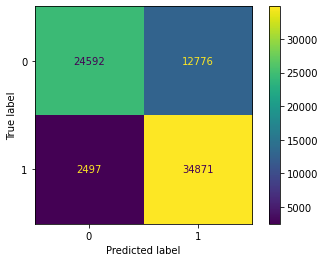

In [30]:
plot_confusion_matrix(gridAB,X_train_mix, y_train,values_format='d' );

In [50]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24592/ (24592 + 12776)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24592 / (24592 + 2497)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.66
Predito Negativo: 0.91


In [21]:
FP = 12776
FN = 2497
VP = 34871
VN = 24592
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 20.44%
Erro Falso Positivo: 34.19%
Erro Falso Negativo: 6.68%


**RFE**

In [31]:
gridAB.fit(X_train_RFE, y_train)

print("best:", gridAB.best_params_)
print("score:", gridAB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridAB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'n_estimators': 10000, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
score: 0.7931108773829998
 
Acurácia:  0.7972
Intervalo da acurácia: [78.96, 80.48]
 
Precision:  0.8224
Recall:  0.7972
F1 Score:  0.7931
AUROC:  0.7972


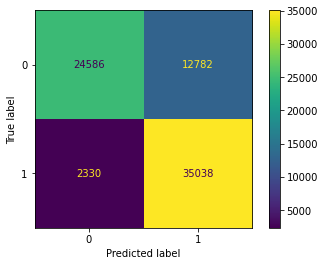

In [32]:
plot_confusion_matrix(gridAB,X_train_RFE, y_train,values_format='d' );

In [49]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24586 / (24586 + 12782)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24586 / (24586 + 2330)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.66
Predito Negativo: 0.91


In [20]:
FP = 12782
FN = 2330
VP = 35038
VN = 24586
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 20.22%
Erro Falso Positivo: 34.21%
Erro Falso Negativo: 6.24%


## Gradiente Boosting

In [33]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_GB = GradientBoostingClassifier()

# grid parâmetros
param_gridGB = {'loss':['deviance', 'exponential'],
                'learning_rate': [0.001,0.01,0.1,1,10,100,1000],
                'n_estimators': [10,100,1000,10000],
                'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],              
                'min_samples_split': [1,2,3,5,7,9,10],
                'min_samples_leaf':[1,2,3,5,7,9,10],
                'max_depth': [1,2,3,5,7,9,10],
                'max_features': ['auto', 'sqrt', 'log2', None]}

                 
# instanciando o RandomizedSearch
gridGB = RandomizedSearchCV(model_GB,
                    param_gridGB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [34]:
gridGB.fit(X_train_mix, y_train)

print("best:", gridGB.best_params_)
print("score:", gridGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.9, 'n_estimators': 10000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.01}
score: 0.790948027592682
 
Acurácia:  0.7946
Intervalo da acurácia: [78.50, 80.42]
 
Precision:  0.8168
Recall:  0.7946
F1 Score:  0.7909
AUROC:  0.7946


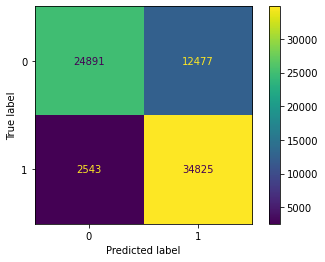

In [35]:
plot_confusion_matrix(gridGB,X_train_mix, y_train,values_format='d' );

In [47]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24891 / (24891  + 12477)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24891 / (24891   + 2543)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.67
Predito Negativo: 0.91


In [19]:
FP = 12477
FN = 2543
VP = 34825
VN = 24891
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 20.10%
Erro Falso Positivo: 33.39%
Erro Falso Negativo: 6.81%


**RFE**

In [36]:
gridGB.fit(X_train_RFE, y_train)

print("best:", gridGB.best_params_)
print("score:", gridGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.9, 'n_estimators': 10000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.01}
score: 0.7958135653338689
 
Acurácia:  0.7991
Intervalo da acurácia: [79.04, 80.79]
 
Precision:  0.8198
Recall:  0.7991
F1 Score:  0.7958
AUROC:  0.7991


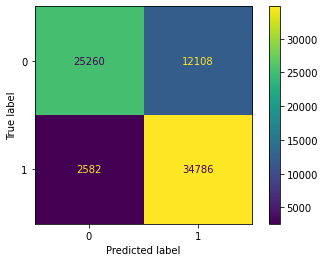

In [37]:
plot_confusion_matrix(gridGB,X_train_RFE, y_train,values_format='d' );

In [46]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 25260 / (25260  + 12108)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 25260 / (25260   + 2582)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.68
Predito Negativo: 0.91


In [18]:
FP = 12108
FN = 2582
VP = 34786
VN = 25260
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 19.66%
Erro Falso Positivo: 32.40%
Erro Falso Negativo: 6.91%


## XGBoost

In [10]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_XGB = XGBClassifier()


# grid parâmetros
param_gridXGB = {'min_child_weight': [1, 5, 10],
                 'gamma': [0.5, 1, 1.5, 2, 5],
                 'subsample': [0.6, 0.8, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0],
                 'max_depth':range(1,10),
                 'eta': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                 'n_estimators': [10,100,1000,10000],
                 'scale_pos_weight': [1, 5, 10]}

# Métricas retiradas por conta da demora no treino
#'booster': ['gbtree', 'gblinear', 'dart'],
#'tree_method': ['exact', 'approx', 'hist', 'gpu_hist']
                
# instanciando o RandomizedSearch
gridXGB = RandomizedSearchCV(model_XGB,
                    param_gridXGB,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [46]:
gridXGB.fit(X_train_mix, y_train)

print("best:", gridXGB.best_params_)
print("score:", gridXGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridXGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[10:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best: {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 1, 'gamma': 0.5, 'eta': 0.7, 'colsample_bytree': 0.8}
score: 0.791165218332124
 
Acurácia:  0.7949
Intervalo da acurácia: [78.57, 80.40]
 
Precision:  0.8172
Recall:  0.7949
F1 Score:  0.7912
AUROC:  0.7949


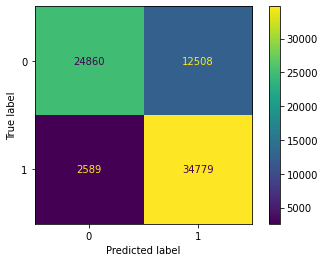

In [47]:
plot_confusion_matrix(gridXGB,X_train_mix, y_train,values_format='d' );

In [45]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24860 / (24860 + 12508)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24860 / (24860  + 2589)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.67
Predito Negativo: 0.91


In [17]:
FP = 12508
FN = 2589
VP = 24779
VN = 24860
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 23.32%
Erro Falso Positivo: 33.47%
Erro Falso Negativo: 9.46%


**RFE**

In [11]:
gridXGB.fit(X_train_RFE, y_train)

print("best:", gridXGB.best_params_)
print("score:", gridXGB.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridXGB)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[20:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best: {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 1, 'gamma': 0.5, 'eta': 0.7, 'colsample_bytree': 0.8}
score: 0.7951837885955704
 
Acurácia:  0.7985
Intervalo da acurácia: [78.96, 80.74]
 
Precision:  0.8192
Recall:  0.7985
F1 Score:  0.7952
AUROC:  0.7985


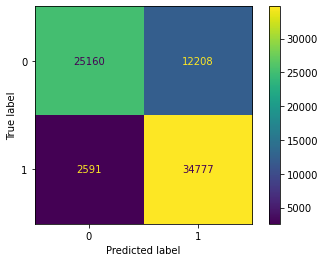

In [12]:
plot_confusion_matrix(gridXGB,X_train_RFE, y_train,values_format='d' );

In [44]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 25160 / (25160 + 12208)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 25160 / (25160  + 2591)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.67
Predito Negativo: 0.91


In [16]:
FP = 12208
FN = 2591
VP = 34777
VN = 25160
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 19.80%
Erro Falso Positivo: 32.67%
Erro Falso Negativo: 6.93%


## LightGBM

In [12]:
# Cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# Definindo algoritimo
model_LGBM = lgb.LGBMClassifier()


# grid parâmetros
param_gridLGBM = {'learning_rate': [0.005, 0.01],
                  'n_estimators': [100, 1000, 10000],
                  'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
                  'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
                  'objective' : ['binary'],
                  'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
                  'colsample_bytree' : [0.64, 0.65, 0.66],
                  'subsample' : [0.7, 0.8, 0.9],
                  'reg_alpha' : [1,1.2],
                  'reg_lambda' : [1,1.2,1.4]}

                 
# instanciando o RandomizedSearch
gridLGBM = RandomizedSearchCV(model_LGBM,
                    param_gridLGBM,
                    scoring=custom_scorer,
                    refit='f1',
                    cv=cv, 
                    return_train_score=True,
                    verbose = 2,
                    n_jobs= 2,
                    random_state=SEED)


**MIX**

In [14]:
gridLGBM.fit(X_train_mix, y_train)

print("best:", gridLGBM.best_params_)
print("score:", gridLGBM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridLGBM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 6, 'n_estimators': 10000, 'max_bin': 255, 'learning_rate': 0.01, 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
score: 0.7911953588630258
 
Acurácia:  0.7951
Intervalo da acurácia: [78.58, 80.45]
 
Precision:  0.8193
Recall:  0.7951
F1 Score:  0.7912
AUROC:  0.7951


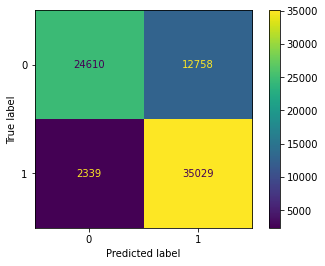

In [15]:
plot_confusion_matrix(gridLGBM,X_train_mix, y_train,values_format='d' );

In [43]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 24610 / (24610 + 12758)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 24610 / (24610  + 2339)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.66
Predito Negativo: 0.91


In [15]:
FP = 12758
FN = 2339
VP = 35029
VN = 24610
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 20.20%
Erro Falso Positivo: 34.14%
Erro Falso Negativo: 6.26%


**RFE**

In [13]:
gridLGBM.fit(X_train_RFE, y_train)

print("best:", gridLGBM.best_params_)
print("score:", gridLGBM.best_score_)
print(" ")

# imprimindo os resultados
metricas(gridLGBM)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best: {'subsample': 0.7, 'reg_lambda': 1.4, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 10000, 'max_bin': 510, 'learning_rate': 0.01, 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
score: 0.7962996529859787
 
Acurácia:  0.7998
Intervalo da acurácia: [79.14, 80.81]
 
Precision:  0.8216
Recall:  0.7998
F1 Score:  0.7963
AUROC:  0.7998


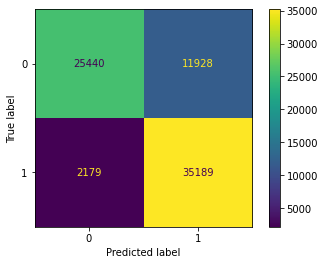

In [14]:
plot_confusion_matrix(gridLGBM,X_train_RFE, y_train,values_format='d' );

In [42]:
# Calculo dos valores focados na melhoria da classe 0

# especificidade = vn / (vn + fp) -> analisa os 0 verdadeiros 
especificidade = 25440 / (25440  + 11928)

# VALOR_PREDITIVO_NEGATIVO =  vn/ (vn + fn) -> analisa os 0  preditos
predito_negativo = 25440 / (25440  + 2179)

print ('Especificidade: {:0.2f}'.format(round(especificidade,2)))
print ('Predito Negativo: {:0.2f}'.format(round(predito_negativo,2)))

Especificidade: 0.68
Predito Negativo: 0.92


In [11]:
FP = 11928
FN = 2179
VP = 35189
VN = 25440
total = FP + FN + VP + VN


diagonal_segundaria= FP + FN
classe_1 = VP + FN
classe_0 = VN + FP

porcentagem_erro_total = (diagonal_segundaria *100)/total
porcentagem_erro_FP = (FP *100)/classe_0
porcentagem_erro_FN = (FN *100)/classe_1
 

print('Erro Global: {:0.2f}%'.format(round(porcentagem_erro_total,2)))
print ('Erro Falso Positivo: {:0.2f}%'.format(round(porcentagem_erro_FP,2)))
print ('Erro Falso Negativo: {:0.2f}%'.format(round(porcentagem_erro_FN,2)))

Erro Global: 18.88%
Erro Falso Positivo: 25.32%
Erro Falso Negativo: 7.89%


# Testando o Modelo

In [10]:
X_test =X_test.drop(columns= ['id'])

In [11]:
X_test = X_test.rename (columns={'Vehicle_Age_< 1 Year': 'Vehicle_Age_maior_1Year',
                           'Vehicle_Age_> 2 Years':'Vehicle_Age_maior_2Year'})
X_test_RFE = X_test[['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
                       'Gender_Male', 'Previously_Insured_1', 'Vehicle_Age_maior_1Year',
                       'Vehicle_Age_maior_2Year', 'Vehicle_Damage_Yes']]

In [13]:
model = lgb.LGBMClassifier (subsample = 0.7, 
                       reg_lambda = 1.4,
                       reg_alpha = 1, 
                       objective = 'binary',
                       num_leaves = 16, 
                       n_estimators = 10000, 
                       max_bin = 510, 
                       learning_rate = 0.01,
                       colsample_bytree = 0.64,
                       boosting_type = 'dart',              
                       random_state=SEED,
                       verbose=2, n_jobs=-1)
    
    
model.fit(X_train_RFE, y_train)
y_pred = model.predict(X_test_RFE)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 37368, number of negative: 37368
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.766170
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.349825
[LightGBM] [Debug] init for col-wise cost 0.001536 seconds, init for row-wise cost 0.004727 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 74736, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 6
[LightGBM] [Debug] Trained a tree with le

# Salvando o Modelo


In [ ]:
bucket = 'insurance-prediction'
folder = 'processing'
key = 'model_pickle'

s3_resource = boto3.resource('s3')

pickle_byte_obj = pickle.dumps(model)

s3_resource.Object(bucket,folder,key).put(Body=pickle_byte_obj)           

para usar o modelo salvo , utilize o seguinte código :



In [31]:
from s3fs.core import S3FileSystem
s3_file = S3FileSystem()

bucket = 'insurance-prediction'
folder = 'processing'
data_key = 'model_pickle'

model = pickle.load(s3_file.open('{}/{}/{}'.format(bucket,folder, key)))



In [32]:
model

LGBMClassifier(boosting_type='dart', colsample_bytree=0.64, learning_rate=0.01,
               max_bin=510, n_estimators=10000, num_leaves=16,
               objective='binary', random_state=42, reg_alpha=1, reg_lambda=1.4,
               subsample=0.7, verbose=2)

# Conclusão

Dentre todos os modelos, o melhores foram:

- Para a classe 1: SVM, utilizando as features selecionadas pelo métodos RFE
- Para a classe 0: LightGMB, utilizando as features selecionadas pelo métodos RFE

Nesse trabalho, optou-se pela escolha do modelo que foi melhor para a classe 0, pois entende-se que definir  com maior precisão as pessoas que não possuem interresse no seguro veicular evita um gasto de marketing/ canais de venda. 